<a href="https://colab.research.google.com/github/Ali-Sab/aps360_project/blob/main/APS360_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim
import requests
torch.manual_seed(50)

In [2]:
# import audio libraries
import os
from os import listdir
from os.path import join
from scipy.io import wavfile
import IPython.display as ipd

import librosa
from librosa.feature import melspectrogram
from librosa import power_to_db
from librosa.effects import trim

In [3]:
#Plot size
plt.rcParams['figure.figsize'] = [12, 8]

In [4]:
#Download team data from Google Drive
if(not os.path.exists("./team_data.zip")):
    team_data_url = "https://drive.google.com/uc?export=download&id=1eycnGtDVzqW57EUBEQmJDPz2F1Dqgqdc" #All data
    #team_data_url = "https://drive.google.com/uc?export=download&id=104eyGYcZADgDiZ1_PLtLGQvx0MIbaKtY" #Excluding angie's data

    resp = requests.get(team_data_url, stream=True)

    with open("./team_data.zip", 'wb') as fd:
        for chunk in resp.iter_content(chunk_size=128):
            fd.write(chunk)

In [5]:
#Download Kaggle data from Google Drive
if(not os.path.exists("./KaggleFSDD.zip")):
    kaggle_data_url = "https://drive.google.com/uc?export=download&id=1Uoy-XzAqE12FIPdqf9adFz7dfTcjDI9N"

    resp = requests.get(kaggle_data_url, stream=True)

    with open("./KaggleFSDD.zip", 'wb') as fd:
        for chunk in resp.iter_content(chunk_size=128):
            fd.write(chunk)

In [6]:
#if(not os.path.exists("./team_recordings")):
!unzip './team_data.zip' -d './team_recordings'

Archive:  ./team_data.zip
   creating: ./team_recordings/all/
  inflating: ./team_recordings/all/0_1 (2).wav  
  inflating: ./team_recordings/all/0_1 (3).wav  
  inflating: ./team_recordings/all/0_1 (4).wav  
  inflating: ./team_recordings/all/0_1.wav  
  inflating: ./team_recordings/all/0_2 (2).wav  
  inflating: ./team_recordings/all/0_2 (3).wav  
  inflating: ./team_recordings/all/0_2 (4).wav  
  inflating: ./team_recordings/all/0_2.wav  
  inflating: ./team_recordings/all/0_3 (2).wav  
  inflating: ./team_recordings/all/0_3 (3).wav  
  inflating: ./team_recordings/all/0_3 (4).wav  
  inflating: ./team_recordings/all/0_3.wav  
  inflating: ./team_recordings/all/1_1 (2).wav  
  inflating: ./team_recordings/all/1_1 (3).wav  
  inflating: ./team_recordings/all/1_1 (4).wav  
  inflating: ./team_recordings/all/1_1.wav  
  inflating: ./team_recordings/all/1_2 (2).wav  
  inflating: ./team_recordings/all/1_2 (3).wav  
  inflating: ./team_recordings/all/1_2 (4).wav  
  inflating: ./team_rec

In [7]:
if(not os.path.exists("./kaggle_recordings")):
    !unzip './KaggleFSDD.zip' -d './kaggle_recordings'

Archive:  ./KaggleFSDD.zip
  inflating: ./kaggle_recordings/.gitignore  
  inflating: ./kaggle_recordings/README.md  
  inflating: ./kaggle_recordings/__init__.py  
  inflating: ./kaggle_recordings/acquire_data/say_numbers_prompt.py  
  inflating: ./kaggle_recordings/acquire_data/split_and_label_numbers.py  
  inflating: ./kaggle_recordings/metadata.py  
  inflating: ./kaggle_recordings/pip_requirements.txt  
  inflating: ./kaggle_recordings/recordings/0_george_0.wav  
  inflating: ./kaggle_recordings/recordings/0_george_1.wav  
  inflating: ./kaggle_recordings/recordings/0_george_10.wav  
  inflating: ./kaggle_recordings/recordings/0_george_11.wav  
  inflating: ./kaggle_recordings/recordings/0_george_12.wav  
  inflating: ./kaggle_recordings/recordings/0_george_13.wav  
  inflating: ./kaggle_recordings/recordings/0_george_14.wav  
  inflating: ./kaggle_recordings/recordings/0_george_15.wav  
  inflating: ./kaggle_recordings/recordings/0_george_16.wav  
  inflating: ./kaggle_recording

In [8]:
# load audio files
def load_files(files, X, y):
    for file in files:
        label = int(file.split("_")[0])
        rate, data = wavfile.read(join(dir, file))
        X.append(data.astype(np.float32))
        y.append(label)
    return rate

X = []
y = []

# load team recordings
dir = './team_recordings/all' #change to /all for all
files = listdir(dir)
rate1 = load_files(files, X, y)

# load Kaggle recordings
dir = './kaggle_recordings/recordings'
files = listdir(dir)
rate2 = load_files(files, X, y)

rate = min(rate1, rate2)

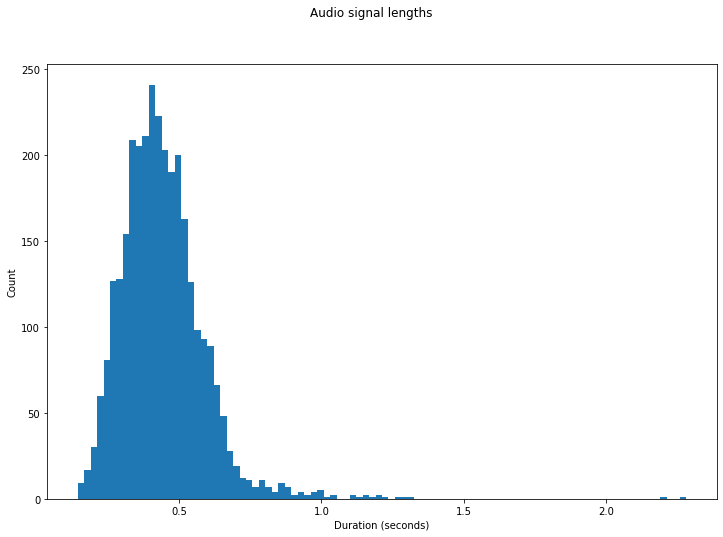

0.6635624999999996


In [9]:
# check distribution of length of audio clips

def show_length_distribution(signals, rate=8000):
    sample_times = [len(x)/rate for x in signals]

    fig = plt.figure()
    plt.hist(x=sample_times, bins = 'fd')
    fig.suptitle('Audio signal lengths')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')

    plt.show()
    return sample_times

lengths = show_length_distribution(X)
print(np.percentile(lengths, 95))

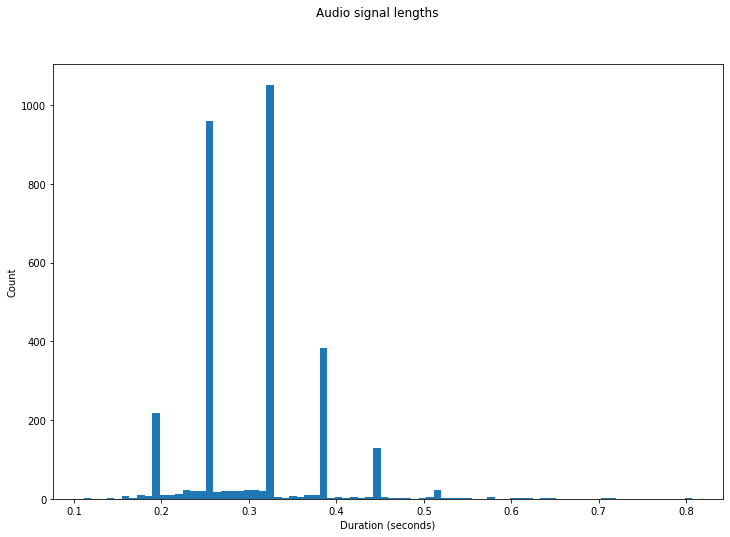

0.512


In [10]:
def remove_silence(sample, sr= 8000, top_db = 5):
    """This function removes trailing and leading silence periods of audio signals.
    """
    y = np.array(sample, dtype = np.float64)
    #y = librosa.util.normalize(y)
    # Trim the beginning and ending silence
    yt, _ = trim(y, top_db= top_db)
    return yt
X_tr = [remove_silence(x) for x in X]

lengths = show_length_distribution(X_tr);
print(np.percentile(lengths, 99))

In [11]:
# pad all clips to same length

N = int(rate * 0.5)
X_uniform = []
for x in X_tr:
    if len(x) < N:
        X_uniform.append(np.pad(x, (0, N - len(x)), constant_values = (0, 0)))
    else:
        X_uniform.append(x[:N])

Digit: 9


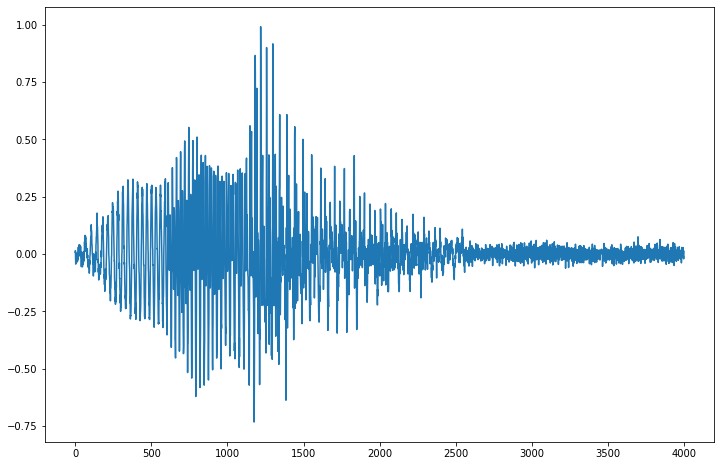

In [12]:
# playback some audio clips

index = 120
print("Digit: {}".format(y[index]))
norm = librosa.util.normalize(X_uniform[index])
norm += np.random.normal(0, 0.02, 4000)
plt.plot(norm)
plt.show()
ipd.Audio(norm, rate=8000)

(126, 126)


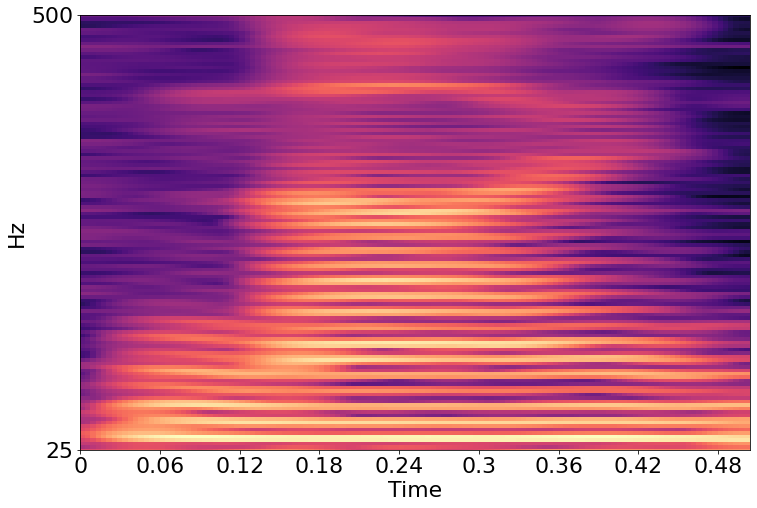

In [45]:
from librosa import display

S = librosa.util.normalize(X_uniform[0])
S = librosa.feature.melspectrogram(y=X_uniform[0], sr=8000, n_fft=1024, hop_length=32, n_mels=126)
print(S.shape)

display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='mel', fmin=25, fmax=500, sr=8000, hop_length=32)

# Need to transpose first to get n_mel/timestep format
S = S.transpose()

#print(S[0])

#from scipy import signal
#frequencies, times, spectrogram = signal.spectrogram(X_uniform[4], 8000)
#plt.pcolormesh(times, frequencies, spectrogram)
#plt.imshow(spectrogram)
#plt.ylabel('Frequency [Hz]')
#plt.xlabel('Time [sec]')

#plt.show()
#for x in X_uniform[0]:
#   print(x)

In [14]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Form the training, validation, and test sets
def get_data_sets(data, labels, training_percentage=0.7, use_mel=False):
    # subtraction is necessary below because we are using integers and do not want any data to be unused because of rounding down the integers
    train_len = int(len(data)*training_percentage)
    val_len = int(len(data)*(1-training_percentage)/2)
    test_len = len(data) - train_len - val_len

    if(use_mel):
        # Get melspectrograms of each sample
        mel_list = []
        for i in range(len(data)):
            S = librosa.feature.melspectrogram(y=data[i], sr=8000, n_fft=1024, hop_length=44)
            S = np.kron(S, np.ones((1, 20)))
            S = S.flatten()
            mel_list.append(S)
        x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(mel_list, labels, test_size=val_len, random_state=1)
    else:
        x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(data, labels, test_size=val_len, random_state=1)

    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x_train, y_train, test_size=test_len, random_state=1)

    return x_train, y_train, x_val, y_val, x_test, y_test

# Calc
def get_accuracy(classifier, x_data, y_data):
    pred = rfc.predict(x_data)
    correct = 0
    total = len(pred)
    for i in range(len(pred)):
        correct += pred[i] == y_data[i]

    return correct/total

def get_accuracy_by_class(classifier, x_data, y_data):
    pred = rfc.predict(x_data)
    classes = max(y_data) + 1
    correct = [0]*classes
    total = [0]*classes
    for i in range(len(pred)):
        correct[y_data[i]] += pred[i] == y_data[i]
        total[y_data[i]] += 1
    acc = [x / y for x, y in zip(correct, total)]

    return acc

In [15]:
#For baseline model, will need to implement random forest classifier
#Will use the following links as guides: (moreso the second link)
#https://medium.com/@pratyush.sinha/training-random-forest-by-back-propagation-for-fun-pytorch-part-1-a54674355aa7
#https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652

rfc = RandomForestClassifier(random_state=10, n_estimators=100, max_features=100, warm_start=True, min_samples_leaf=10, verbose=True, n_jobs=-1)
x_train, y_train, x_val, y_val, x_test, y_test = get_data_sets(X_uniform[120:], y[120:], use_mel=True)
rfc.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=100,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=10,
                       verbose=True, warm_start=True)

In [16]:
print("Validation Accuracy: {}%".format(100*get_accuracy(rfc, x_val, y_val)))
print("Test Accuracy: {}%".format(100*get_accuracy(rfc, x_test, y_test)))

X_unseen = []
for i in range(120):
    S = librosa.feature.melspectrogram(y=X_uniform[i], sr=8000, n_fft=1024, hop_length=44)
    S = np.kron(S, np.ones((1, 20)))
    S = S.flatten()
    X_unseen.append(S)
print("Unseen Accuracy: {}%".format(100*get_accuracy(rfc, X_unseen, y[:120])))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Validation Accuracy: 92.66666666666666%


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Test Accuracy: 87.55555555555556%
Unseen Accuracy: 57.49999999999999%


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [17]:
val_acc_class = get_accuracy_by_class(rfc, x_val, y_val)
val_acc_class[:] = [x * 100 for x in val_acc_class]
test_acc_class = get_accuracy_by_class(rfc, x_test, y_test)
test_acc_class[:] = [x * 100 for x in test_acc_class]

print("Validation accuracy of each class from 0 to 9:")
print('\n'.join('{}: {}%'.format(*k) for k in enumerate(val_acc_class)))
print("Test accuracy of each class from 0 to 9:")
print('\n'.join('{}: {}%'.format(*k) for k in enumerate(test_acc_class)))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Validation accuracy of each class from 0 to 9:
0: 91.66666666666666%
1: 93.75%
2: 95.0%
3: 84.375%
4: 93.87755102040816%
5: 88.23529411764706%
6: 94.0%
7: 100.0%
8: 92.5925925925926%
9: 91.48936170212765%
Test accuracy of each class from 0 to 9:
0: 96.0%
1: 96.0%
2: 90.0%
3: 70.73170731707317%
4: 94.44444444444444%
5: 74.46808510638297%
6: 90.0%
7: 92.0%
8: 97.61904761904762%
9: 72.72727272727273%


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


# Deep Learning Models

In [18]:
class DigitRecognitionNet1(nn.Module):
    def __init__(self):
        super(DigitRecognitionNet1, self).__init__()
        self.name = 'DigitRecognitionNet1'
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 14 * 14, 100)
        self.fc2 = nn.Linear(100, 10)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv3(x)))
        #print(x.shape)
        x = x.view(-1, 32 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc2(self.dropout1(x))
        #x = self.dropout2(x)
        #x = x.squeeze(1) # Flatten to [batch_size]
        return x
    
class DigitRecognitionNet2(nn.Module):
    def __init__(self):
        super(DigitRecognitionNet2, self).__init__()
        self.name = 'DigitRecognitionNet2'
        self.conv1 = nn.Conv2d(1, 5, 2)
        self.conv2 = nn.Conv2d(5, 25, 2)
        self.conv3 = nn.Conv2d(25, 50, 3)
        self.fc1 = nn.Linear(50 * 124 * 117, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 50 * 124 * 117)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = x.squeeze(1) # Flatten to [batch_size]
        return x
    
class DigitRecognitionNet3(nn.Module):
    def __init__(self):
        super(DigitRecognitionNet3, self).__init__()
        self.name = 'DigitRecognitionNet3'
        self.conv1 = nn.Conv2d(1, 5, 3)
        self.conv2 = nn.Conv2d(5, 25, 3)
        self.fc1 = nn.Linear(25 * 124 * 117, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 25 * 124 * 117)
        x = F.relu(self.fc1(x))
        #x = x.squeeze(1) # Flatten to [batch_size]
        return x
    
class DigitRecognitionNet4(nn.Module):
    def __init__(self):
        super(DigitRecognitionNet4, self).__init__()
        self.name = 'DigitRecognitionNet4'
        self.fc1 = nn.Linear(128 * 121, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 128 * 121)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [19]:
# After receiving necessary tensors
from torch.utils.data import DataLoader

def get_data_loader(data, batch_size, training_percentage=0.8):
    # subtraction is necessary below because we are using integers and do not want any data to be unused because of rounding down the integers
    train_len = int(len(data)*training_percentage)
    val_len = len(data) - train_len
    #test_len = len(data) - train_len - val_len
    print(len(data), train_len, val_len)
    train_set, val_set = torch.utils.data.random_split(data, [train_len, val_len])

    train_loader = DataLoader(train_set, batch_size, shuffle=True)
    if val_len > 0:
        val_loader = DataLoader(val_set, batch_size, shuffle=True)
    else:
        val_loader = []
    '''if test_len > 0:
        test_loader = DataLoader(test_set, batch_size, shuffle=True)
    else:
        test_loader = []'''

    return train_loader, val_loader#, test_loader

batch_size = 64

In [20]:
def train_net(net, data, batch_size=64, learning_rate=1e-3, num_epochs=30, training_percentage=0.8, weight_decay=0, save_checkpoint=True):
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader = get_data_loader(
            data, batch_size, training_percentage)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_correct = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            net.train()
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            #############################################
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            #print(inputs)
            #print(outputs)
            #print(labels)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            pred = outputs.max(1, keepdim=True)[1]
            total_train_correct += pred.eq(labels.view_as(pred)).sum().item()
            total_epoch += inputs.shape[0]
            total_train_loss += loss.item()

        train_err[epoch] = float(total_epoch - total_train_correct) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        if save_checkpoint:
          torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

# Evaluating accuracy
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

      Args:
          net: PyTorch neural network object
          loader: PyTorch data loader for the validation set
          criterion: The loss function
      Returns:
          err: A scalar for the avg classification error over the validation set
          loss: A scalar for the average loss function over the validation set
      """
    net.eval()
    total_loss = 0.0
    total_correct = 0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
        #############################################
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        pred = outputs.max(1, keepdim=True)[1]
        total_correct += pred.eq(labels.view_as(pred)).sum().item()
        total_epoch += inputs.shape[0]
        total_loss += loss.item()
    if total_epoch == 0:
        print("No data in loader")
        return 1,1
    err = float(total_epoch-total_correct) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

    # Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [21]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    print(X.min())
    print(X.max())
    return X_scaled

from torch.utils.data import TensorDataset

use_mel = True
X_final = []
if(use_mel):
    # Get melspectrograms of each sample
    for i in range(len(X_uniform)):
        noise = np.random.normal(0, 0.02, 4000)
        normalized = librosa.util.normalize(X_uniform[i])
        if (i > 1500): normalized += noise #1500 so only half have noise
        S = librosa.feature.melspectrogram(y=normalized, n_fft=1024, hop_length=32, sr=8000)
        mellog = np.log(S + 1e-9)
        melnormalized = librosa.util.normalize(mellog)
        #S = np.kron(S, np.ones((1, 11)))
        X_final.append(melnormalized)
else:
    X_final = X_uniform
    
'''X_np = np.array(X_final)
print(X_np.max())
print(X_np.mean())
X_np = np.clip(X_np, 0, X_np.mean()*4)    # 1600 mels is 2000hz, which is the highest frequency we expect from a person
X_final = scale_minmax(X_np, 0, 1)'''
X_tensor = torch.Tensor(X_final)
y_tensor = torch.Tensor(y).long()

X_tensor = X_tensor.unsqueeze(1)
print(X_tensor.shape)
print(y_tensor.shape)
print(X_tensor[0])
print(y_tensor[0])

train_dataset = TensorDataset(X_tensor[90:], y_tensor[90:])
unseen_data = TensorDataset(X_tensor[:90], y_tensor[:90])
print(len(train_dataset), len(unseen_data))

torch.Size([3120, 1, 128, 126])
torch.Size([3120])
tensor([[[-0.1285, -0.1280, -0.1203,  ...,  0.1612,  0.1610,  0.1607],
         [-0.3687, -0.3420, -0.2993,  ...,  0.0607,  0.0641,  0.0652],
         [-0.2364, -0.2392, -0.2415,  ...,  0.1580,  0.1627,  0.1642],
         ...,
         [-0.9326, -0.9362, -0.9463,  ..., -0.7745, -0.7774, -0.7772],
         [-0.7556, -0.7595, -0.7704,  ..., -0.8454, -0.8530, -0.8547],
         [-0.6771, -0.6804, -0.6895,  ..., -0.7744, -0.7708, -0.7695]]])
tensor(9)
3030 90


In [22]:
use_cuda = True

Using Cuda
3030 2424 606
Epoch 1: Train err: 0.8473597359735974, Train loss: 2.4247496128082275 |Validation err: 0.7211221122112211, Validation loss: 2.1338122844696046
Epoch 2: Train err: 0.5721947194719472, Train loss: 1.527720244307267 |Validation err: 0.37623762376237624, Validation loss: 0.9548666834831238
Epoch 3: Train err: 0.27516501650165015, Train loss: 0.7421651231615167 |Validation err: 0.12376237623762376, Validation loss: 0.4077808201313019
Epoch 4: Train err: 0.16914191419141913, Train loss: 0.4759462773799896 |Validation err: 0.09075907590759076, Validation loss: 0.28453588485717773
Epoch 5: Train err: 0.11386138613861387, Train loss: 0.3340792875540884 |Validation err: 0.06765676567656766, Validation loss: 0.24060469269752502
Epoch 6: Train err: 0.08044554455445545, Train loss: 0.22887986231791346 |Validation err: 0.07425742574257425, Validation loss: 0.20936397612094879
Epoch 7: Train err: 0.0594059405940594, Train loss: 0.1752596787716213 |Validation err: 0.044554455

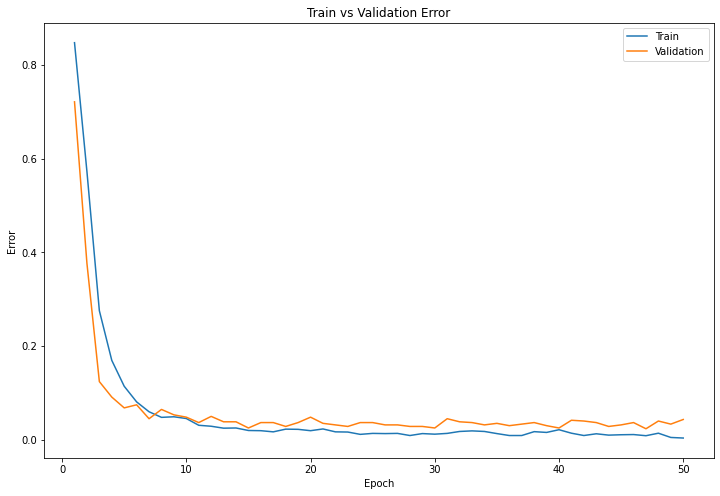

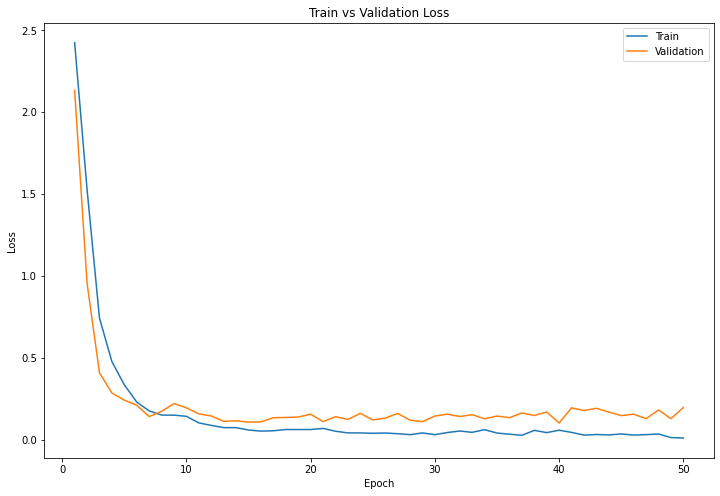

In [23]:
net1 = DigitRecognitionNet1()
if use_cuda and torch.cuda.is_available():
  net1 = net1.cuda()
  print("Using Cuda")
train_net(net1, train_dataset, batch_size=128, learning_rate=0.01, num_epochs=50, training_percentage=0.8, weight_decay=0, save_checkpoint=False)
plot_training_curve(get_model_name("DigitRecognitionNet1", 128, 0.01, 49))

In [24]:
unseen_loader = DataLoader(unseen_data, 128)
err, loss = evaluate(net1, unseen_loader, nn.CrossEntropyLoss())
print(err, loss)

0.37777777777777777 6.110510349273682


In [25]:
# Evaluating accuracy
def evaluate_class(net, loader, criterion, classes):
    """ Evaluate the network on the validation set.

      Args:
          net: PyTorch neural network object
          loader: PyTorch data loader for the validation set
          criterion: The loss function
      Returns:
          err: A scalar for the avg classification error over the validation set
          loss: A scalar for the average loss function over the validation set
      """
    net.eval()

    correct = [0]*classes
    total = [0]*classes
    print(correct)

    for i, data in enumerate(loader, 0):
        inputs, labels = data
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
        #############################################
        outputs = net(inputs)
        #print(outputs)
        loss = criterion(outputs, labels)
        pred = outputs.max(1, keepdim=True)[1]
        #print(pred)
        for j in range(len(pred)):
          correct[labels[j].item()] += pred[j][0].item() == labels[j].item()
          total[labels[j].item()] += 1

    print(correct)
    print(total)
    return np.array(correct)/np.array(total)

In [26]:
train_loader, val_loader = get_data_loader(
          train_dataset, 64, 0.8)


class_accuracies_val = evaluate_class(net1, val_loader, nn.CrossEntropyLoss(), 10)

3030 2424 606
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[67, 65, 62, 52, 64, 54, 59, 63, 63, 54]
[67, 65, 63, 52, 65, 54, 59, 64, 63, 54]


In [27]:
class_accuracies_unseen = evaluate_class(net1, unseen_loader, nn.CrossEntropyLoss(), 10)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[6, 8, 4, 8, 5, 7, 3, 5, 4, 6]
[10, 8, 7, 10, 7, 11, 10, 7, 10, 10]


In [28]:
val_acc_class

[91.66666666666666,
 93.75,
 95.0,
 84.375,
 93.87755102040816,
 88.23529411764706,
 94.0,
 100.0,
 92.5925925925926,
 91.48936170212765]

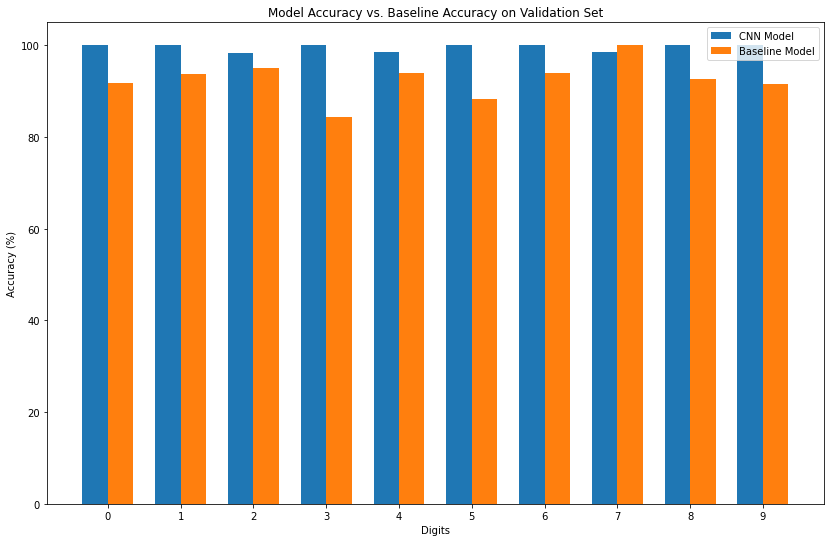

In [29]:
import matplotlib

ind = np.arange(10)
fig, ax = plt.subplots()

width = 0.35

rect = ax.bar(ind-width/2, class_accuracies_val*100, width, label='CNN Model')
rect2 = ax.bar(ind+width/2, val_acc_class, width, label='Baseline Model')

ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracy vs. Baseline Accuracy on Validation Set')
ax.set_xlabel('Digits')
ax.set_xticks(ind)
ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.legend()

matplotlib.rcParams.update({'font.size': 22})

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
fig.tight_layout()
plt.show()

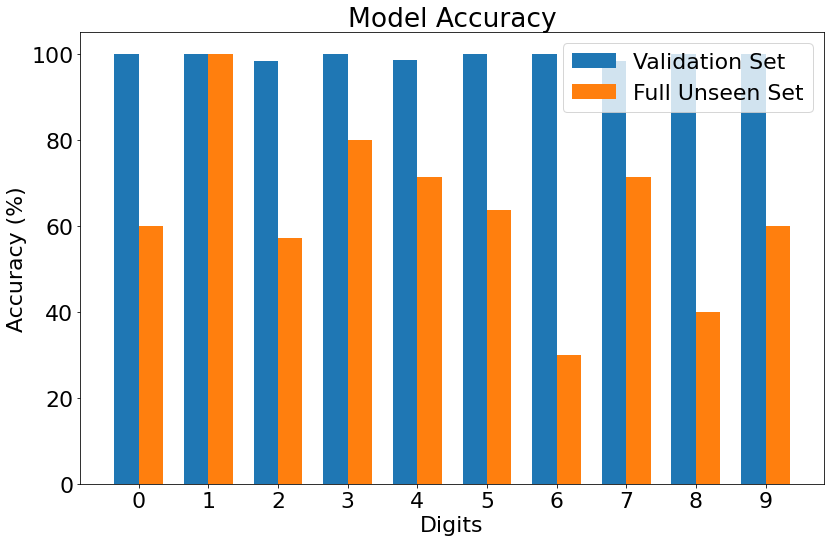

In [30]:
ind = np.arange(10)
fig, ax = plt.subplots()

width = 0.35

rect = ax.bar(ind-width/2, class_accuracies_val*100, width, label='Validation Set')
rect2 = ax.bar(ind+width/2, class_accuracies_unseen*100, width, label='Full Unseen Set')

ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracy')
ax.set_xlabel('Digits')
ax.set_xticks(ind)
ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.legend()

matplotlib.rcParams.update({'font.size': 22})

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
fig.tight_layout()
plt.show()

### Demo Code

Digit: 2


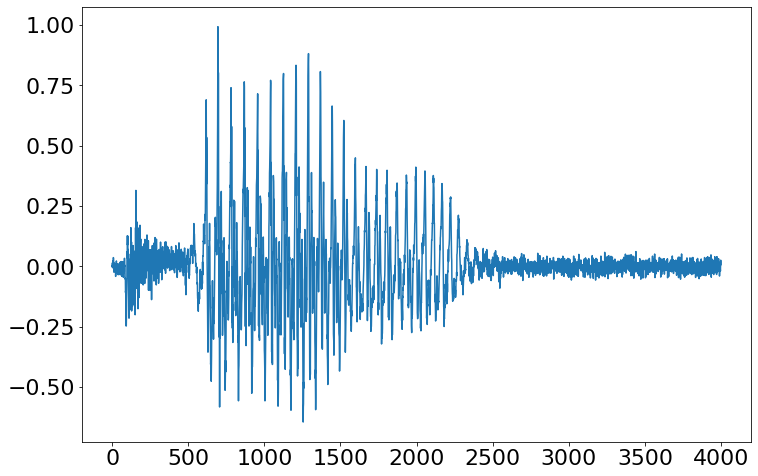

In [88]:
# playback some audio clips

test_index1 = 1
print("Digit: {}".format(y[test_index1]))
norm = librosa.util.normalize(X_uniform[test_index1])
norm += np.random.normal(0, 0.02, 4000)
plt.plot(norm)
plt.show()
ipd.Audio(norm, rate=8000)

Digit: 3


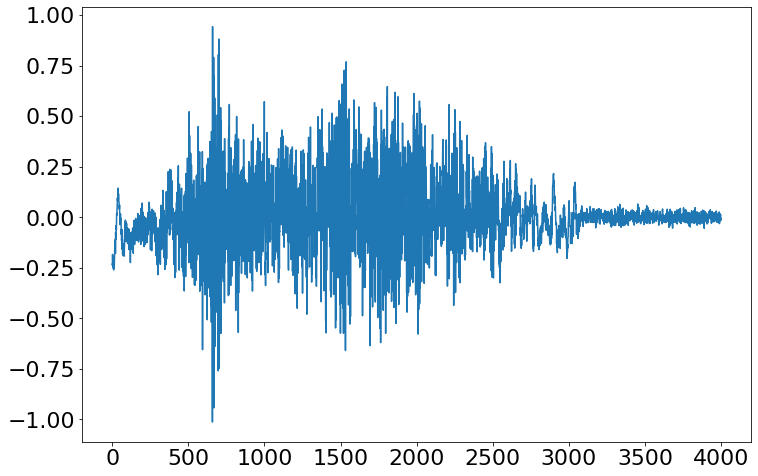

In [89]:
test_index2 = 20
print("Digit: {}".format(y[test_index2]))
norm = librosa.util.normalize(X_uniform[test_index2])
norm += np.random.normal(0, 0.02, 4000)
plt.plot(norm)
plt.show()
ipd.Audio(norm, rate=8000)

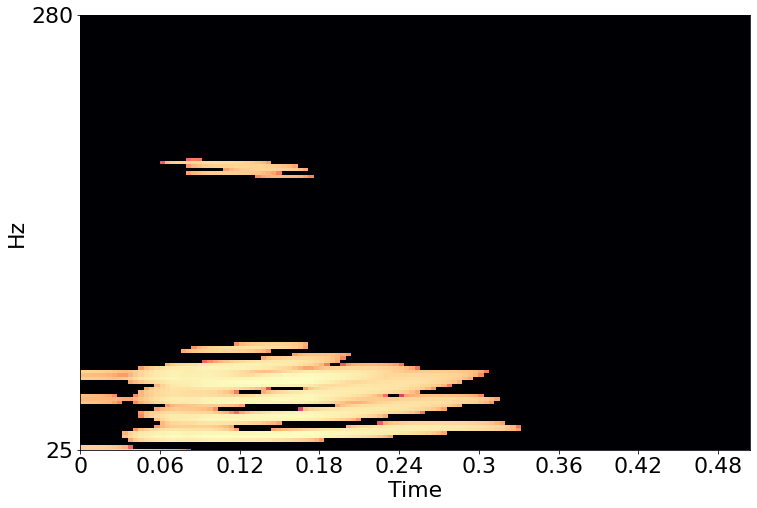

In [90]:
display.specshow(librosa.power_to_db(unseen_loader.dataset[test_index1][0][0], ref=np.max), x_axis='time', y_axis='mel', fmin=25, fmax=280, sr=8000, hop_length=32)

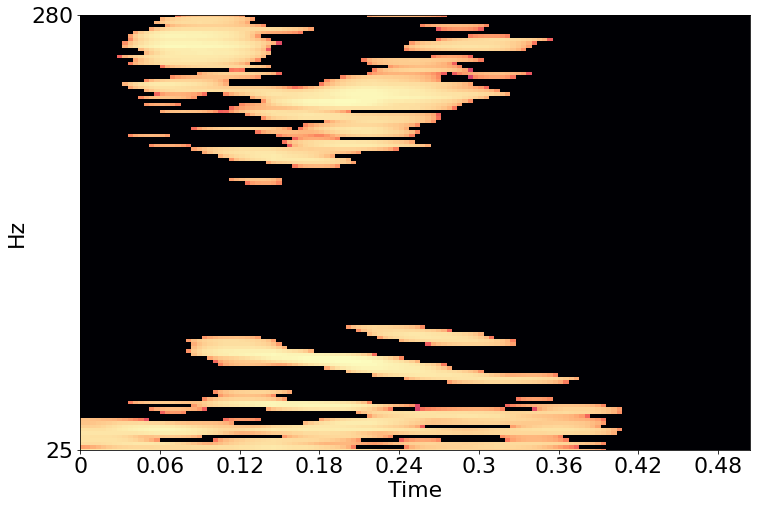

In [91]:
display.specshow(librosa.power_to_db(unseen_loader.dataset[test_index2][0][0], ref=np.max), x_axis='time', y_axis='mel', fmin=25, fmax=280, sr=8000, hop_length=32)

In [96]:
test1_tensor = unseen_loader.dataset[test_index1][0]
test1_tensor = test1_tensor.unsqueeze(0)
test2_tensor = unseen_loader.dataset[test_index2][0]
test2_tensor = test2_tensor.unsqueeze(0)
print(test1_tensor.shape)

if use_cuda and torch.cuda.is_available():
  test1_tensor = test1_tensor.cuda()
  test2_tensor = test2_tensor.cuda()

output1 = net1(test1_tensor)
pred1 = output1.max(1, keepdim=True)[1]

output2 = net1(test2_tensor)
pred2 = output2.max(1, keepdim=True)[1]
print("\n\nThe digit at index", test_index1, "is", pred1.item())
print("The digit at index", test_index2, "is", pred2.item())

torch.Size([1, 1, 128, 126])


The digit at index 1 is 2
The digit at index 20 is 3


### Unused Code

In [ ]:
net2 = DigitRecognitionNet2()
if use_cuda:
  net2 = net2.cuda()
train_net(net2, dataset, batch_size=64, learning_rate=1e-3, num_epochs=600, training_percentage=0.8, weight_decay=0.001, save_checkpoint=False)
plot_training_curve(get_model_name("DigitRecognitionNet2", 64, 1e-3, 599))

In [ ]:
net3 = DigitRecognitionNet3()
if use_cuda:
  net3 = net3.cuda()
train_net(net3, dataset, batch_size=75, learning_rate=1e-3, num_epochs=600, training_percentage=0.7, weight_decay=0, save_checkpoint=False)
plot_training_curve(get_model_name("DigitRecognitionNet3", 64, 1e-3, 599))

In [ ]:
net4 = DigitRecognitionNet4()
if use_cuda:
  net4 = net4.cuda()
train_net(net4, dataset, batch_size=64, learning_rate=1e-4, num_epochs=200, training_percentage=0.7, weight_decay=0, save_checkpoint=False)
plot_training_curve(get_model_name("DigitRecognitionNet4", 64, 1e-4, 199))